In [3]:
import torch
import numpy as np
import slayerSNN as snn
from pathlib import Path
import logging
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [4]:
output_size = 20
lr = 0.01

data_dir='/home/tasbolat/some_python_examples/data_VT_SNN/'
batch_size=8
sample_file=2
epochs = 500

In [5]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 10,
        "tauSr": 10.0,
        "tauRef": 1.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 325, "nSample": 1},
    "training": {
        "error": {
            "type": "NumSpikes",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 325,
            },
            "tgtSpikeCount": {True: 150, False: 5},
        }
    },
}

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
class ViTacMMDataset(Dataset):
    def __init__(self, path, sample_file, output_size):
        self.path = path
        tact = torch.load(Path(path) / "tact.pt")
        self.tact = tact.reshape(tact.shape[0], -1, 1, 1, tact.shape[-1])
        self.ds_vis = torch.load(Path(path) / "ds_vis.pt")
        self.samples = np.loadtxt(Path(path) / sample_file).astype("int")
        self.output_size = output_size

    def __getitem__(self, index):
        input_index = self.samples[index, 0]
        class_label = self.samples[index, 1]
        target_class = torch.zeros((self.output_size, 1, 1, 1))
        target_class[class_label, ...] = 1

        return (
            self.tact[input_index],
            self.ds_vis[input_index],
            target_class,
            class_label,
        )

    def __len__(self):
        return self.samples.shape[0]

In [8]:
train_dataset = ViTacMMDataset(
    path=data_dir, sample_file=f"train_80_20_{sample_file}.txt", output_size=output_size
)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)
test_dataset = ViTacMMDataset(
    path=data_dir, sample_file=f"test_80_20_{sample_file}.txt", output_size=output_size
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

In [9]:
class EncoderVis(torch.nn.Module):
    def __init__(self, netParams, output_size):
        super(EncoderVis, self).__init__()
        self.slayer = snn.layer(netParams['neuron'], netParams['simulation'])
        self.fc1   = self.slayer.dense((50, 63, 2), output_size)
    def forward(self, downsampled):
        spikeLayer1 = self.slayer.spike(self.slayer.psp(downsampled)) # 32, 32, 16
        spikeLayer5 = self.slayer.spike(self.fc1(self.slayer.psp(spikeLayer1))) #  10
        self.spike_trains = [spikeLayer1]
        return spikeLayer5

class EncoderTact(torch.nn.Module):
    def __init__(self, netParams, output_size):
        super(EncoderTact, self).__init__()
        slayer = snn.layer(netParams['neuron'], netParams['simulation'])
        self.slayer = slayer
        self.fc1   = slayer.dense(156, output_size)
    def forward(self, spikeInput):
        spikeLayer1 = self.slayer.spike(self.fc1(self.slayer.psp((spikeInput))))
        self.spike_trains = []
        return spikeLayer1

class SlayerMM(torch.nn.Module):
    def __init__(self, netParams, output_size):
        super(SlayerMM, self).__init__()
        slayer = snn.layer(netParams['neuron'], netParams['simulation'])
        self.tactile = EncoderTact(netParams, 32)
        self.vision = EncoderVis(netParams, 20)
        self.slayer = slayer
        self.fc1   = slayer.dense(52, output_size)

    def forward(self, spikeInputTact, spikeInputVis):
        spikeLayer1 = self.tactile(spikeInputTact)
        spikeLayer2 = self.vision(spikeInputVis)
        spikeAll = torch.cat([spikeLayer1, spikeLayer2], dim=1)
        self.spike_trains = [spikeAll] + self.tactile.spike_trains + self.vision.spike_trains

        out = self.slayer.spike(self.slayer.psp(self.fc1(spikeAll)))
        return out

In [10]:
class SlayerMLP(torch.nn.Module):
    '''
    2 layer MLP based on SLAYER used for tactile data
    '''
    def __init__(self, params, input_size, hidden_size, output_size):
        super(SlayerMLP, self).__init__()
        self.output_size = output_size
        self.slayer = snn.layer(params["neuron"], params["simulation"])
        self.fc1 = self.slayer.dense(input_size, hidden_size)
        self.fc2 = self.slayer.dense(hidden_size, output_size)

    def forward(self, spike_input):
        spike_1 = self.slayer.spike(self.slayer.psp(self.fc1(spike_input)))
        spike_output = self.slayer.spike(self.slayer.psp(self.fc2(spike_1)))
        self.spike_trains = [spike_1]
        return spike_output

In [11]:
device = torch.device("cuda:2")
net = SlayerMM(params, output_size).to(device)

In [12]:
# apply weights
net_tact = SlayerMLP(params, 156,32,20).to(device)
net_vis = EncoderVis(params, 20).to(device)

In [13]:
net_tact.load_state_dict(torch.load('tactile_model.pt'))
net_vis.load_state_dict(torch.load('vision_model.pt'))

<All keys matched successfully>

In [14]:
count = 0
for param in net_tact.parameters():
    print(count, param.data.shape)
    count += 1

0 torch.Size([32, 156, 1, 1, 1])
1 torch.Size([20, 32, 1, 1, 1])


In [15]:
with torch.no_grad():
    # set tactile
    net.tactile.fc1.weight = net_tact.fc1.weight
    #net.tactile.fc1.weight.requires_grad = False
    # set vision
    net.vision.fc1.weight = net_vis.fc1.weight
    #net.vision.fc1.weight.requires_grad = False

In [16]:
param.requires_grad

True

In [17]:
count = 0
for param in net.parameters():
    print(count, param.data.shape, param.requires_grad)
    count += 1

0 torch.Size([32, 156, 1, 1, 1]) True
1 torch.Size([20, 2, 63, 50, 1]) True
2 torch.Size([20, 52, 1, 1, 1]) True


In [18]:
count_parameters(net)

132032

In [19]:
error = snn.loss(params).to(device)
optimizer = torch.optim.RMSprop(
    net.parameters(), lr=0.01, weight_decay=0.5
)

In [20]:
tr_losses=[]
te_losses=[]
tr_accs=[]
te_accs=[]


for epoch in range(1, epochs+1):
    correct = 0
    num_samples = 0
    batch_loss = 0
    net.train()
    for i, (tact, vis, target, label) in enumerate(train_loader):
        
        tact = tact.to(device)
        vis = vis.to(device)
        target = target.to(device)
        output = net.forward(tact, vis)
        
        correct += torch.sum(snn.predict.getClass(output) == label).data.item()
        loss = error.numSpikes(output, target)
        batch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    tr_losses.append(batch_loss / len(train_loader.dataset) )
    tr_accs.append(correct / len(train_loader.dataset) )
    
    correct = 0
    num_samples = 0
    batch_loss = 0
    net.eval()
    with torch.no_grad():
        for i, (tact, vis, target, label) in enumerate(test_loader):

            tact = tact.to(device)
            vis = vis.to(device)
            target = target.to(device)
            output = net.forward(tact, vis)

            correct += torch.sum(snn.predict.getClass(output) == label).data.item()
            loss = error.numSpikes(output, target)
            batch_loss += loss.item()

    te_losses.append(batch_loss / len(test_loader.dataset) )
    te_accs.append(correct / len(test_loader.dataset) )
    
    if epoch%50 == 0:
        print('Epoch ', epoch, '---------------------------------')
        print('Train, Test acc: ', tr_accs[-1], te_accs[-1])

Epoch  50 ---------------------------------
Train, Test acc:  1.0 0.5666666666666667
Epoch  100 ---------------------------------
Train, Test acc:  0.9875 0.7
Epoch  150 ---------------------------------
Train, Test acc:  1.0 0.7166666666666667
Epoch  200 ---------------------------------
Train, Test acc:  1.0 0.8
Epoch  250 ---------------------------------
Train, Test acc:  1.0 0.7833333333333333
Epoch  300 ---------------------------------
Train, Test acc:  1.0 0.75
Epoch  350 ---------------------------------
Train, Test acc:  0.9916666666666667 0.7333333333333333
Epoch  400 ---------------------------------
Train, Test acc:  0.9958333333333333 0.7166666666666667
Epoch  450 ---------------------------------
Train, Test acc:  1.0 0.7166666666666667
Epoch  500 ---------------------------------
Train, Test acc:  1.0 0.7333333333333333


In [21]:
torch.save(net.state_dict(), 'mm_model_v2.pt')

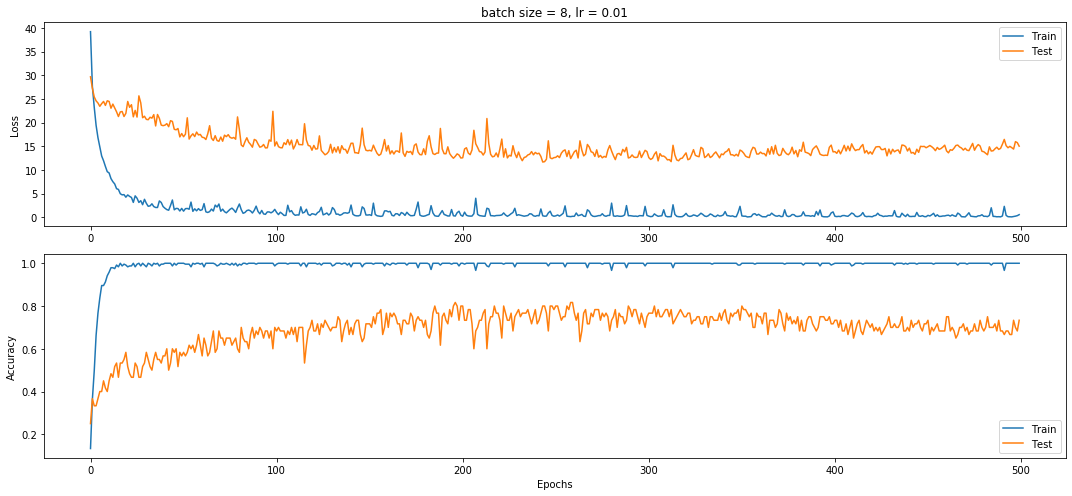

In [22]:
fig, ax = plt.subplots(2, figsize=(15,7))
ax[0].set_title('batch size = ' + str(batch_size) + ', lr = ' + str(lr))
ax[0].plot(tr_losses)
ax[0].plot(te_losses)
ax[0].legend(['Train', 'Test'])
ax[0].set_ylabel('Loss')

ax[1].plot(tr_accs)
ax[1].plot(te_accs)
ax[1].legend(['Train', 'Test'])
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
plt.tight_layout()
#fig.savefig('results/vis_'+str(batch_size) + '_' + str(lr) +'.png')

plt.show()

The below figure for version 1 (fixed weights)

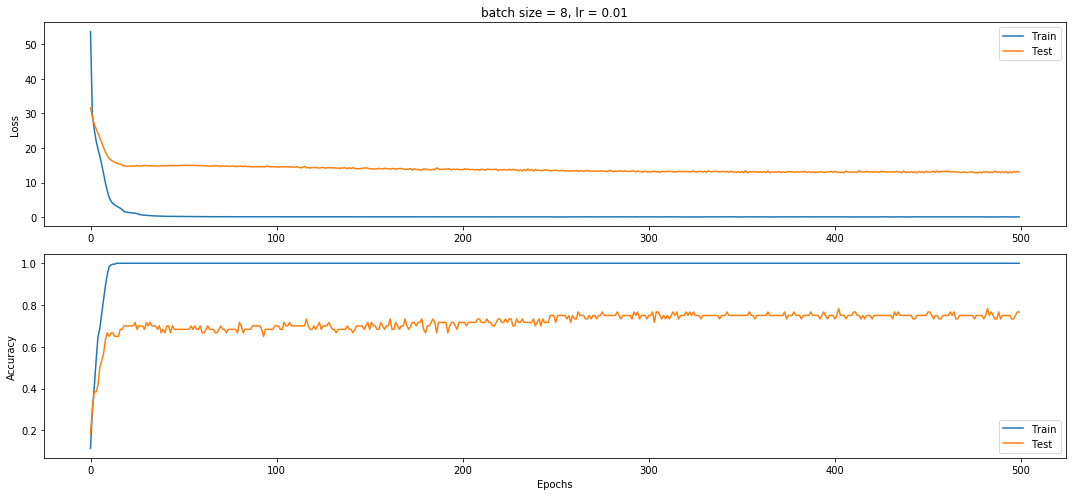

In [148]:
fig, ax = plt.subplots(2, figsize=(15,7))
ax[0].set_title('batch size = ' + str(batch_size) + ', lr = ' + str(lr))
ax[0].plot(tr_losses)
ax[0].plot(te_losses)
ax[0].legend(['Train', 'Test'])
ax[0].set_ylabel('Loss')

ax[1].plot(tr_accs)
ax[1].plot(te_accs)
ax[1].legend(['Train', 'Test'])
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
plt.tight_layout()
#fig.savefig('results/vis_'+str(batch_size) + '_' + str(lr) +'.png')

plt.show()